In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium_stealth import stealth
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import numpy as np                                          
import pandas as pd                                        
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import plotly.express as px

from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split

import time
import re

In [2]:
options = webdriver.ChromeOptions()
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
options.add_argument('--disable-blink-features=AutomationControlled')
options.add_argument('--window-size=1920,1080')
options.add_experimental_option("excludeSwitches", ["enable-automation"])
options.add_experimental_option('useAutomationExtension', False)

service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

stealth(driver,
        languages=["ru-RU", "ru", "en-US", "en"],
        vendor="Google Inc.",
        platform="Win32",
        webgl_vendor="Intel Inc.",
        renderer="Intel Iris OpenGL Engine",
        fix_hairline=True)

I. Data Collection  
◦ You should collect your own data: Scrap website (KZ) or collect survey from some KZ company  
  
OZON.KZ - PC setups

In [ ]:
link = "https://ozon.kz/category/sistemnye-bloki-15704/"
driver.get(link)
time.sleep(5)

raw_tile_texts = []
seen_texts = set()

for scroll_step in range(150):
    driver.execute_script(f"window.scrollTo(0, {scroll_step * 800});")
    time.sleep(1.5)
    
    soup = BeautifulSoup(driver.page_source, "html.parser")
    current_tiles = soup.select("div[class*='tile']")
    
    print(f"Scroll {scroll_step+1}: {len(current_tiles)} tiles")
    
    for tile in current_tiles:
        tile_text = tile.get_text(" ", strip=True)
        
        if tile_text not in seen_texts:
            raw_tile_texts.append(tile_text)
            seen_texts.add(tile_text[:200])

print(f"\nTiles saved: {len(raw_tile_texts)}")

Scroll 1: 12 tiles
Scroll 2: 24 tiles
Scroll 3: 24 tiles
Scroll 4: 36 tiles
Scroll 5: 36 tiles
Scroll 6: 48 tiles
Scroll 7: 48 tiles
Scroll 8: 48 tiles
Scroll 9: 48 tiles
Scroll 10: 48 tiles
Scroll 11: 48 tiles
Scroll 12: 48 tiles
Scroll 13: 48 tiles
Scroll 14: 48 tiles
Scroll 15: 48 tiles
Scroll 16: 48 tiles
Scroll 17: 48 tiles
Scroll 18: 48 tiles
Scroll 19: 48 tiles
Scroll 20: 48 tiles
Scroll 21: 48 tiles
Scroll 22: 48 tiles
Scroll 23: 48 tiles
Scroll 24: 48 tiles
Scroll 25: 48 tiles
Scroll 26: 48 tiles
Scroll 27: 48 tiles
Scroll 28: 48 tiles
Scroll 29: 48 tiles
Scroll 30: 48 tiles
Scroll 31: 48 tiles
Scroll 32: 48 tiles
Scroll 33: 48 tiles
Scroll 34: 48 tiles
Scroll 35: 48 tiles
Scroll 36: 48 tiles
Scroll 37: 48 tiles
Scroll 38: 48 tiles
Scroll 39: 48 tiles
Scroll 40: 48 tiles
Scroll 41: 48 tiles
Scroll 42: 48 tiles
Scroll 43: 48 tiles
Scroll 44: 48 tiles
Scroll 45: 48 tiles
Scroll 46: 48 tiles
Scroll 47: 48 tiles
Scroll 48: 48 tiles
Scroll 49: 48 tiles
Scroll 50: 48 tiles
Scroll 51

In [3]:
def extract_specs(text: str) -> dict:
    t = text.upper()
    
    result = {
        "cpu_brand": "OTHER",
        "cpu_model": "OTHER", 
        "cpu_gen": 0,
        "gpu_brand": "NO_GPU",
        "gpu_series": "INTEGRATED",
        "gpu_gen": 0,
        "ram_gb": 0,
        "rom_gb": 0,
        "reviews": 0,
        "price": 0
    }
    
    if "INTEL" in t:
        result["cpu_brand"] = "INTEL"
        
        if "XEON" in t:
            result["cpu_model"] = "XEON"
            cpu_gen_m = re.search(r'E[57]-?(\d{4,5})', t)
            if cpu_gen_m:
                result["cpu_gen"] = int(cpu_gen_m.group(1)[:2])
        
        elif "CORE ULTRA" in t:
            result["cpu_model"] = "ULTRA CORE"
            ultra_match = re.search(r'CORE ULTRA\s*(\d+)\s*(\d{3})', t)
            if ultra_match:
                model_num = ultra_match.group(2)
                if len(model_num) >= 3:
                    result["cpu_gen"] = int(model_num[0])
        
        else:
            cpu_model_m = re.search(r'(I[3579])', t)
            if cpu_model_m:
                result["cpu_model"] = cpu_model_m.group(1)
                cpu_gen_m = re.search(rf'{result["cpu_model"]}-?(\d{{3,5}})', t)
                if cpu_gen_m:
                    gen_str = cpu_gen_m.group(1)
                    if len(gen_str) == 5:
                        result["cpu_gen"] = int(gen_str[:2])
                    elif len(gen_str) == 4:
                        result["cpu_gen"] = int(gen_str[0])
                    elif len(gen_str) == 3:
                        result["cpu_gen"] = int(gen_str[0])
            
            elif "CORE" in t:
                result["cpu_model"] = "CORE"
                core_match = re.search(r'CORE\s*(?:I?[3579]?\s*)?(\d{3,5})', t)
                if core_match:
                    gen_str = core_match.group(1)
                    if len(gen_str) == 5:
                        result["cpu_gen"] = int(gen_str[:2])
                    elif len(gen_str) == 4:
                        result["cpu_gen"] = int(gen_str[0])
                    elif len(gen_str) == 3:
                        result["cpu_gen"] = int(gen_str[0])
                else:
                    result["cpu_model"] = "OTHER_INTEL"
            
            else:
                if any(x in t for x in ["CORE 2", "PENTIUM", "CELERON", "ATOM", "Q8200", "Q6600"]) or re.search(r'[QE]\d{4}', t):
                    result["cpu_model"] = "OTHER_INTEL"
                    
    elif "AMD" in t:
        result["cpu_brand"] = "AMD"
        
        ryzen_match = re.search(r'RYZEN\s*(\d)\s*(\d{4})', t)
        if ryzen_match:
            result["cpu_model"] = f"RYZEN {ryzen_match.group(1)}"
            result["cpu_gen"] = int(ryzen_match.group(2)[:2])
        else:
            result["cpu_model"] = "OTHER_AMD"
    
    if "NVIDIA" in t:
        result["gpu_brand"] = "NVIDIA"
        gpu_series_m = re.search(r'(RTX|GTX)\s*(\d{3,4})', t)
        if gpu_series_m:
            result["gpu_series"] = gpu_series_m.group(1)
            result["gpu_gen"] = int(gpu_series_m.group(2))
        else:
            result["gpu_series"] = "OTHER_NVIDIA"
            
    elif "RADEON" in t or "RX" in t:
        result["gpu_brand"] = "AMD"
        rx_match = re.search(r'RX\s*(\d{3,4})', t)
        if rx_match:
            result["gpu_series"] = "RX"
            result["gpu_gen"] = int(rx_match.group(1))
        else:
            result["gpu_series"] = "OTHER_AMD"
            
    elif "INTEL" in t and any(x in t for x in ["HD GRAPHICS", "UHD GRAPHICS", "IRIS", "HD", "GRAPHICS"]):
        result["gpu_brand"] = "INTEL"
        result["gpu_series"] = "INTEGRATED_INTEL"
            
    elif "AMD" in t and result["cpu_brand"] == "AMD" and any(x in t for x in ["RADEON", "VEGA", "GRAPHICS"]):
        result["gpu_brand"] = "AMD"
        result["gpu_series"] = "INTEGRATED_AMD"

    ram_match = re.search(r'RAM\s*(\d+)', t)
    if ram_match:
        result["ram_gb"] = int(ram_match.group(1))
    
    ssd_match = re.search(r'SSD\s*(\d+)', t)
    if ssd_match:
        result["rom_gb"] = int(ssd_match.group(1))
    
    price_match = re.search(r'×\s*\d+\s*мес\s*([\d\s ]+)₸', text)
    if price_match:
        result["price"] = int(re.sub(r'\D', '', price_match.group(1)))
    
    reviews_match = re.search(r'(\d+)\s*отзыв', text.lower())
    if reviews_match:
        result["reviews"] = int(reviews_match.group(1))
    
    return result

In [ ]:
all_data = []

for i, tile_text in enumerate(raw_tile_texts):
    specs = extract_specs(tile_text)
    
    name_clean = re.sub(r'^.*?₸.*?(Системный блок|ПК)', '', tile_text).strip()[:100] or f"ПК {i+1}"
    
    product = {
        "name": name_clean,       
        "cpu_brand": specs["cpu_brand"],
        "cpu_model": specs["cpu_model"],
        "cpu_gen": specs["cpu_gen"],
        "gpu_brand": specs["gpu_brand"],
        "gpu_series": specs["gpu_series"],
        "gpu_gen": specs["gpu_gen"],
        "ram_gb": specs["ram_gb"],
        "rom_gb": specs["rom_gb"],
        "reviews": specs["reviews"],
        "price": specs["price"]
    }
    all_data.append(product)

ozon_pcs = pd.DataFrame(all_data).drop_duplicates()

FEATURES = [
    "name",
    "cpu_brand", "cpu_model", "cpu_gen",
    "gpu_brand", "gpu_series", "gpu_gen",
    "ram_gb", "rom_gb",
    "reviews", "price"
]
ozon_pcs = ozon_pcs[FEATURES]

print(ozon_pcs.head())
print(f"\n Pcs without duplicates: {len(ozon_pcs)}")

ozon_pcs.to_csv("ozon_pcs.csv", index=False, encoding="utf-8")

                                                name cpu_brand cpu_model  \
0  (Intel Core i5-9600KF, RAM 16 ГБ, SSD 512 ГБ, ...     INTEL        I5   
1  Tactio 310H6SEA (Intel Core i5-12400F, RAM 16 ...     INTEL        I5   
2  Tactio 310H6AE (Intel Core i5-13400F, RAM 32 Г...     INTEL        I5   
3  (Intel Core i5-12400F, RAM 32 ГБ, SSD 1000 ГБ,...     INTEL        I5   
4  Planio 310H6SEV (Intel Core i3-12100, RAM 16 Г...     INTEL        I3   

   cpu_gen gpu_brand        gpu_series  gpu_gen  ram_gb  rom_gb  reviews  \
0        9    NVIDIA               RTX     2060      16     512        0   
1       12    NVIDIA               RTX     3050      16     512       98   
2       13    NVIDIA               RTX     5060      32    1024       98   
3       12    NVIDIA               RTX     4060      32    1000        0   
4       12     INTEL  INTEGRATED_INTEL        0      16     256       77   

    price  
0  308390  
1  363449  
2  536595  
3  468891  
4  231280  

 Pcs without 

In [2]:
ozon_pcs_data = pd.read_csv("ozon_pcs.csv")
ozon_pcs_data = ozon_pcs_data[ozon_pcs_data['price'] > 0]
ozon_pcs_data.head()

,name,cpu_brand,cpu_model,cpu_gen,gpu_brand,gpu_series,gpu_gen,ram_gb,rom_gb,reviews,price
0,"(Intel Core i5-9600KF, RAM 16 ГБ, SSD 512 ГБ, ...",INTEL,I5,9,NVIDIA,RTX,2060,16,512,0,308390
1,"Tactio 310H6SEA (Intel Core i5-12400F, RAM 16 ...",INTEL,I5,12,NVIDIA,RTX,3050,16,512,98,363449
2,"Tactio 310H6AE (Intel Core i5-13400F, RAM 32 Г...",INTEL,I5,13,NVIDIA,RTX,5060,32,1024,98,536595
3,"(Intel Core i5-12400F, RAM 32 ГБ, SSD 1000 ГБ,...",INTEL,I5,12,NVIDIA,RTX,4060,32,1000,0,468891
4,"Planio 310H6SEV (Intel Core i3-12100, RAM 16 Г...",INTEL,I3,12,INTEL,INTEGRATED_INTEL,0,16,256,77,231280


II. Data Cleaning and Visualization  
◦ Visualize the data statistics: histograms, plots, scatterplots, diagrams, pie charts. Explain  
◦ Use matplotlib or seaborn  
You should have at least 10 visualizations, where 7 of the are different types of visualizations  

Text(0.5, 1.0, 'PC setup prices distribution')

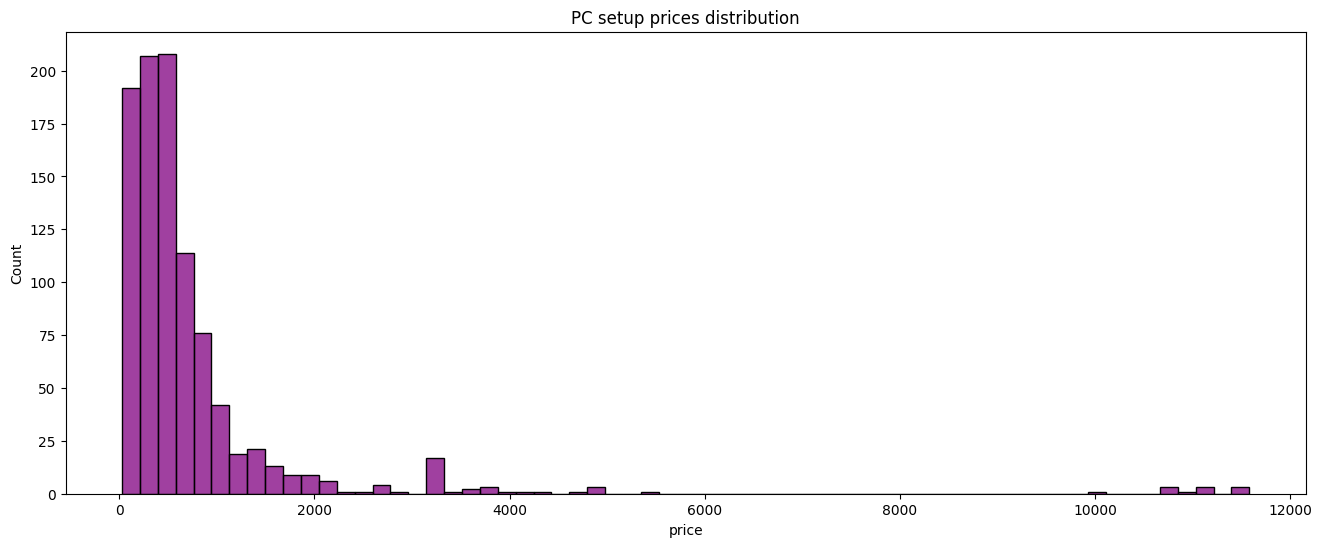

In [3]:
plt.figure(figsize=(16, 6))
sns.histplot(ozon_pcs_data["price"]/1000, color="purple")
plt.title("PC setup prices distribution")

Text(0.5, 1.0, 'PC configuration correlation')

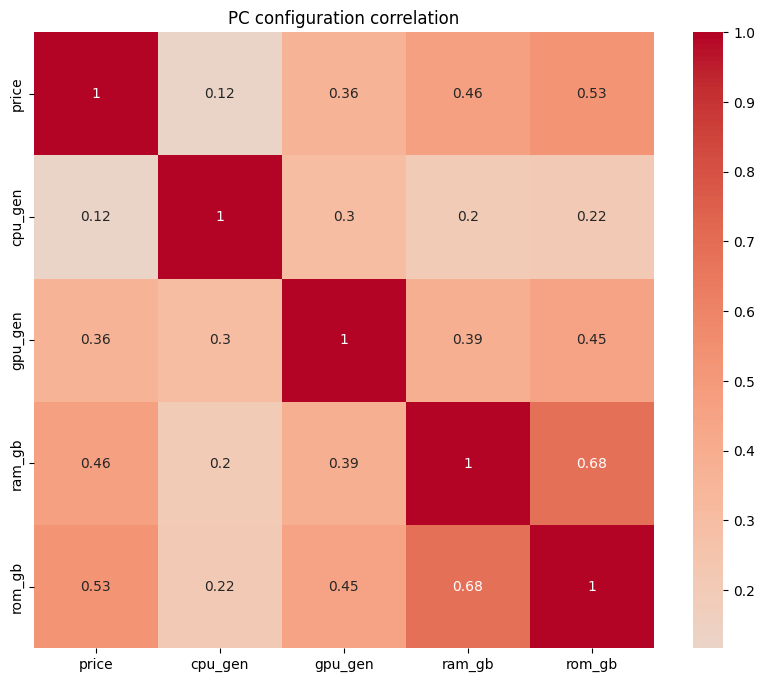

In [4]:
numeric_columns = ["price", "cpu_gen", "gpu_gen", "ram_gb", "rom_gb"]
correlation_data = ozon_pcs_data[numeric_columns]

corr_matrix = correlation_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True,cmap="coolwarm",center=0)

plt.title("PC configuration correlation")

C:\Users\Tima\AppData\Local\Temp\ipykernel_29060\1236695353.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pivot_ram = ozon_pcs_data.groupby(["price_category", "ram_gb"]).size().unstack()


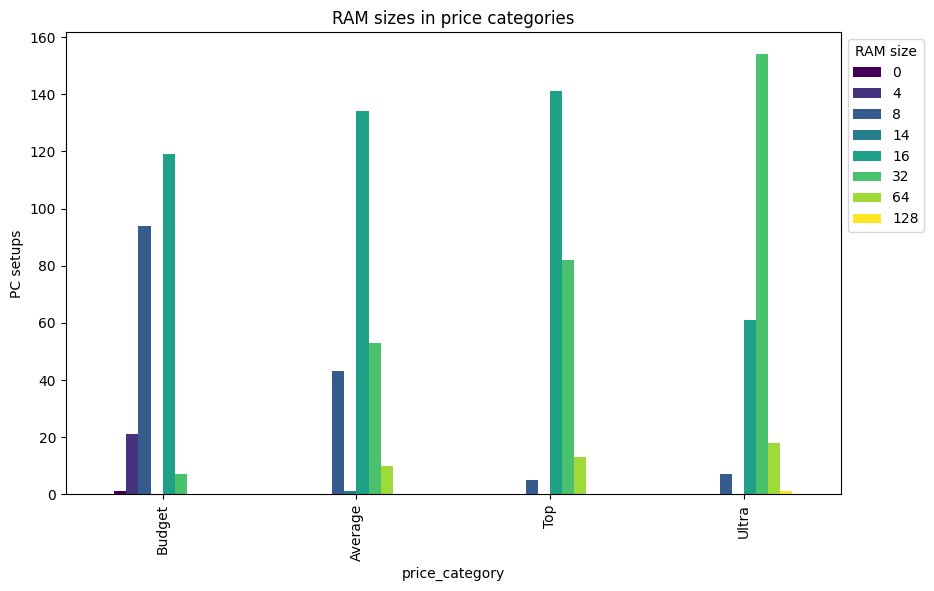

In [5]:
ozon_pcs_data["price_category"] = pd.qcut(ozon_pcs_data["price"], 4, labels=["Budget", "Average", "Top", "Ultra"])

pivot_ram = ozon_pcs_data.groupby(["price_category", "ram_gb"]).size().unstack()
pivot_ram.plot(kind="bar", figsize=(10,6), colormap="viridis")

plt.title("RAM sizes in price categories")
plt.ylabel("PC setups")
plt.legend(title="RAM size", bbox_to_anchor=(1, 1))

Text(0.5, 1.0, 'GPU types in PC setups')

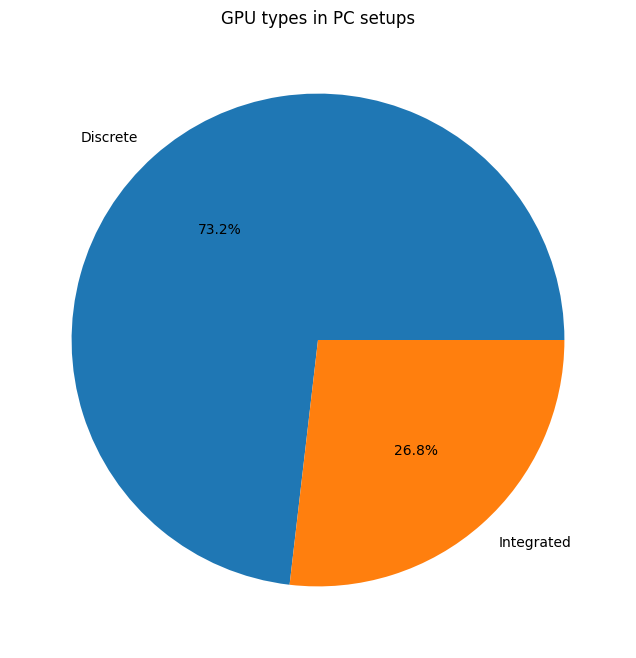

In [6]:
ozon_pcs_data["gpu_type"] = ozon_pcs_data["gpu_gen"].apply(lambda x: "Discrete" if x > 0 else "Integrated")

gpu_counts = ozon_pcs_data["gpu_type"].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(gpu_counts.values, labels=gpu_counts.index,autopct="%1.1f%%")
plt.title("GPU types in PC setups")

Text(0, 0.5, 'Price in Tg')

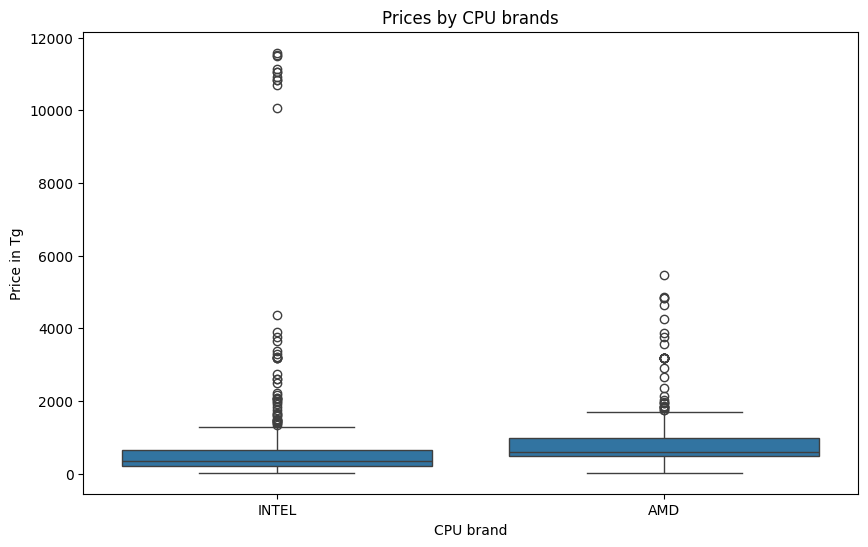

In [7]:
plt.figure(figsize=(10, 6))

sns.boxplot(x="cpu_brand", y=ozon_pcs_data["price"]/1000, data=ozon_pcs_data)

plt.title("Prices by CPU brands")
plt.xlabel("CPU brand")
plt.ylabel("Price in Tg")

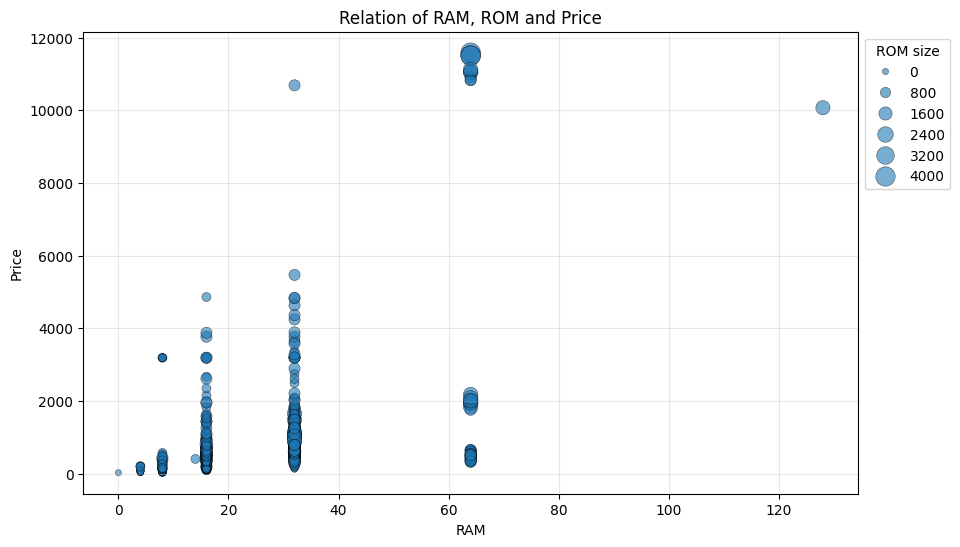

In [8]:
plt.figure(figsize=(10, 6))

sns.scatterplot( data=ozon_pcs_data, x="ram_gb", y=ozon_pcs_data["price"]/1000, size="rom_gb", alpha=0.6, sizes=(20, 200), edgecolor="black")

plt.title("Relation of RAM, ROM and Price")
plt.xlabel("RAM")
plt.ylabel("Price")

plt.legend(title="ROM size", bbox_to_anchor=(1, 1))

plt.grid(True, alpha=0.3)

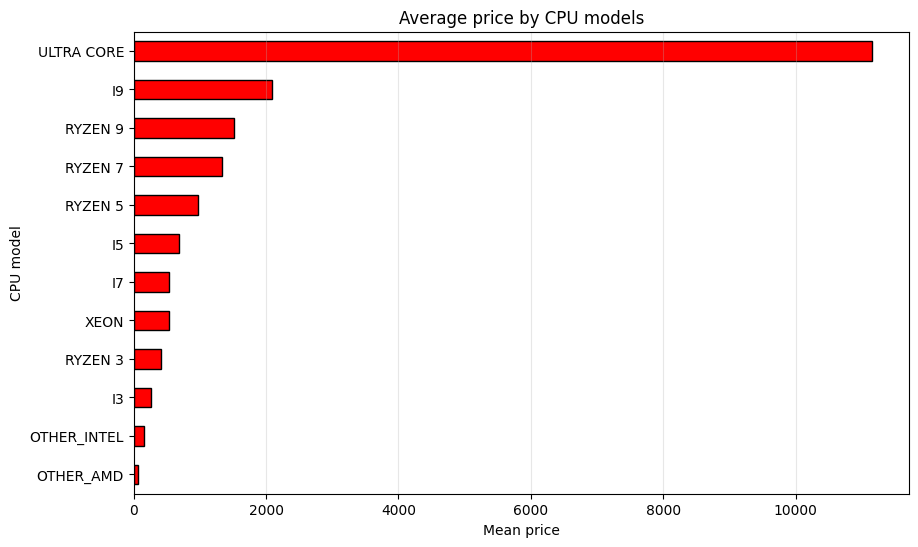

In [9]:
plt.figure(figsize=(10, 6))
average_price_cpu = ozon_pcs_data.groupby("cpu_model")["price"].mean()/1000

average_price_cpu.sort_values().plot(kind="barh", color="red", edgecolor="black")

plt.title("Average price by CPU models")
plt.xlabel("Mean price")
plt.ylabel("CPU model")

plt.grid(True, axis='x', alpha=0.3)

Text(95.7222222222222, 0.5, 'GPU series')

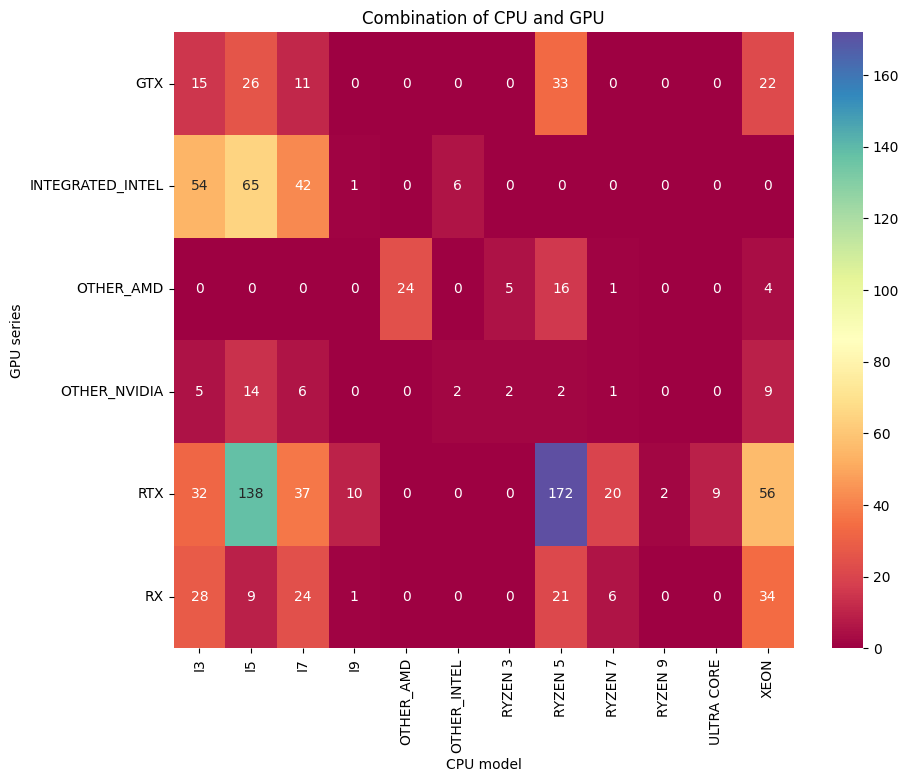

In [10]:
corr_gpu_cpu = pd.crosstab(ozon_pcs_data["gpu_series"], ozon_pcs_data["cpu_model"])

plt.figure(figsize=(10, 8))
sns.heatmap(corr_gpu_cpu, annot=True, fmt="d", cmap="Spectral")
plt.title("Combination of CPU and GPU")
plt.xlabel("CPU model")
plt.ylabel("GPU series")

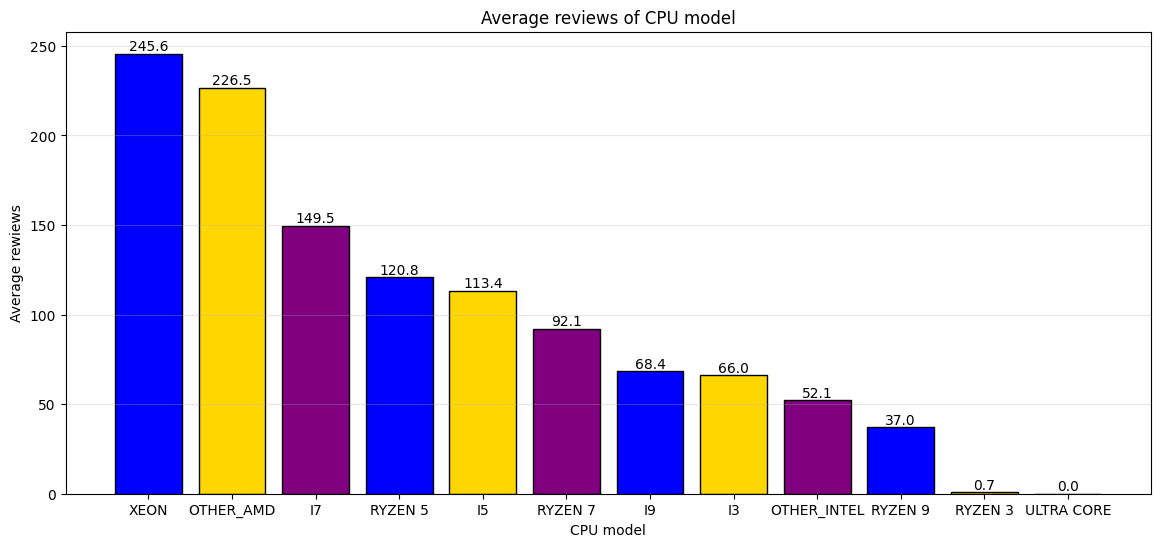

In [11]:
reviews_by_brand = ozon_pcs_data.groupby("cpu_model")["reviews"].mean().sort_values(ascending=False)

plt.figure(figsize=(14, 6))
bars = plt.bar(reviews_by_brand.index, reviews_by_brand.values, color=["blue", "gold", "purple"][:len(reviews_by_brand)],edgecolor="black")

plt.title("Average reviews of CPU model")
plt.xlabel("CPU model")
plt.ylabel("Average rewiews")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,f"{height:.1f}", ha="center", va="bottom")

plt.grid(True, alpha=0.3, axis="y")

In [12]:
gpu_ram_map = ozon_pcs_data.groupby(["gpu_series", "ram_gb"]).size().reset_index(name="count")

fig1 = px.treemap(gpu_ram_map, path=["gpu_series", "ram_gb"], values="count",color="count",color_continuous_scale="Reds",title="Popular combination GPU and RAM")
fig1.show()

III.Data Analytics and Modelling  
◦ Use ML algorithm (or any mathematical/statistical model) for your predictions/classifications. You can use ready python libraries  

In [93]:
df = pd.read_csv("ozon_pcs.csv")
df = df.query("0 < price < 4000000")

X = df.drop(columns=["price"])
y = df["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

y_train_log = np.log1p(y_train)

cat_features = ["cpu_brand", "cpu_model", "cpu_gen", "gpu_brand", "gpu_series", "gpu_gen"]
text_features = ["name"]

model = CatBoostRegressor(iterations=1500, learning_rate=0.03, depth=7, l2_leaf_reg=5, random_seed=42, verbose=300)

model.fit(X_train, y_train_log, cat_features=cat_features, text_features=text_features)

preds_log = model.predict(X_test)
predictions = np.expm1(preds_log)

comparison = pd.DataFrame({"Price": y_test, "prediction": predictions.astype(int)})
print("\n Prediction examples:")
print(comparison.head(10))

0:	learn: 0.8578175	total: 60.6ms	remaining: 1m 30s
300:	learn: 0.1966546	total: 20.1s	remaining: 1m 19s
600:	learn: 0.1503385	total: 39.5s	remaining: 59.1s
900:	learn: 0.1269030	total: 1m	remaining: 40.5s
1200:	learn: 0.1094928	total: 1m 23s	remaining: 20.8s
1499:	learn: 0.0964333	total: 1m 43s	remaining: 0us

 Prediction examples:
       Price  prediction
592   230570      241729
951  1108790     1761991
139   241633      222623
86   1102289     1028871
39    894698      969304
789  1839146     1561225
165   326990      347453
96    904373      857002
198   576180      582337
250   310223      291370


In [133]:
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)
accuracy = (1 - mape) * 100

print(f"MAE: {round(mae)}")
print(f"R2: {round(r2, 2)}")
print(f"Error: {round(mape * 100, 1)}%")
print(f"Accuracy: {round(accuracy, 1)}%")

MAE: 88084
R2: 0.83
Error: 13.9%
Accuracy: 86.1%


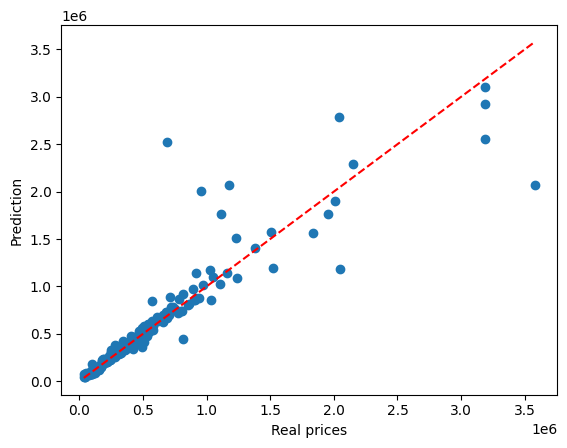

In [134]:
plt.scatter(y_test, predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Real prices")
plt.ylabel("Prediction")
plt.show()

In [138]:
feature_importance = model.get_feature_importance(prettified=True)
print(feature_importance.head(10))

   Feature Id  Importances
0        name    43.833127
1  gpu_series    21.777308
2     cpu_gen    12.408449
3      rom_gb     6.812460
4   cpu_model     3.897506
5      ram_gb     3.772212
6     gpu_gen     3.125904
7     reviews     2.254887
8   cpu_brand     1.083737
9   gpu_brand     1.034410


In [136]:
df_linear = pd.read_csv("ozon_pcs.csv")
df_linear = df_linear.query("0 < price < 4000000")

X_linear = df_linear.drop(columns=["price", "name"])
y_linear = df_linear["price"]

X_linear_numeric = pd.get_dummies(X_linear)

X_linear_train, X_linear_test, y_linear_train, y_linear_test = train_test_split(X_linear_numeric, y_linear, test_size=0.2, random_state=42)

y_linear_train_log = np.log1p(y_train)

linear_model = LinearRegression()
linear_model.fit(X_linear_train, y_linear_train_log)

preds_log_linear = linear_model.predict(X_linear_test)
linear_predictions = np.expm1(preds_log_linear)

comparison = pd.DataFrame({"Price": y_linear_test, "prediction": linear_predictions.astype(int)})
print("\n Prediction examples:")
print(comparison.head(10))


 Prediction examples:
       Price  prediction
592   230570      254092
951  1108790      523427
139   241633      363331
86   1102289      969822
39    894698      643876
789  1839146     1044937
165   326990      442322
96    904373      945887
198   576180      503300
250   310223      370828


In [137]:
mae_linear = mean_absolute_error(y_linear_test, linear_predictions)
r2_linear = r2_score(y_linear_test, linear_predictions)
mape_linear = mean_absolute_percentage_error(y_linear_test, linear_predictions)
accuracy_linear = (1 - mape_linear) * 100

print(f"MAE: {round(mae_linear)}")
print(f"R2: {round(r2_linear, 2)}")
print(f"Error: {round(mape_linear * 100, 1)}%")
print(f"Accuracy: {round(accuracy_linear, 1)}%")

MAE: 176834
R2: 0.44
Error: 28.6%
Accuracy: 71.4%


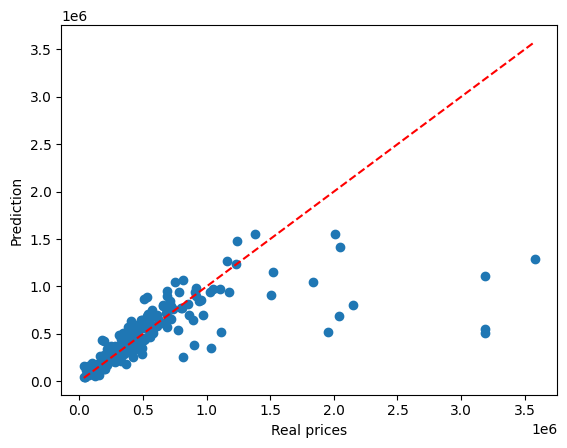

In [110]:
plt.scatter(y_linear_test, linear_predictions)
plt.plot([y_linear_test.min(), y_linear_test.max()], [y_linear_test.min(), y_linear_test.max()], "r--")
plt.xlabel("Real prices")
plt.ylabel("Prediction")
plt.show()